In [1]:
import os
import sys

sys.path.insert(0, "../../")

import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)
import pathlib
from lips.augmented_simulators.tensorflow_models.powergrid import TfResNetPowerGrid

from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.dataset.scaler import  StandardScaler

from lips.config import ConfigManager
from lips.utils import get_path

In [2]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent.parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_case14_sandbox"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_case14_sandbox.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

# 1. l2rpn_case14_sandbox grid

## 1.1 Benchmark1: Risk assessment through contingency screening

In [3]:
benchmark1 = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH
                               )

In [4]:
bench_config = ConfigManager(section_name="Benchmark1", path=BENCH_CONFIG_PATH)
topo_actions = bench_config.get_option("dataset_create_params")["reference_args"]["topo_actions"]

kwargs_tau = []
for el in topo_actions:
     kwargs_tau.append(el["set_bus"]["substations_id"][0])
                       
kwargs_tau

[(4, (2, 1, 2, 1, 2)), (1, (1, 2, 1, 2, 2, 2)), (5, (1, 1, 2, 2, 1, 2, 2))]

### Tensorflow ResNet 

In [5]:
tf_resnet = TfResNetPowerGrid(name="tf_resnet",
                             bench_config_path=BENCH_CONFIG_PATH,
                             bench_config_name="Benchmark1",
                             topo_vect_to_tau="given_list",
                             kwargs_tau=kwargs_tau,
                             layers = [200, 200, 200],
                             lr = 1e-4,

                             loss = {"name": "mse"},
                             layer = "resnet",
                             activation = "elu",
                           
                             sim_config_path=SIM_CONFIG_PATH / "tf_fc.ini",
                             sim_config_name="DEFAULT",
                             log_path=LOG_PATH,
                             scale_input_layer = True,
                             scaler = StandardScaler,
                                         )

In [ ]:
# import time
start_time = time.time()

In [7]:
tf_resnet.train(train_dataset=benchmark1.train_dataset,
            val_dataset=benchmark1.val_dataset,
            batch_size = 128,
            epochs= 400)

2022-07-22 14:01:53.015215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 14:01:53.501125: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5120 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:03:00.0, compute capability: 8.6


Epoch 1/400
  44/1172 [>.............................] - ETA: 4s - loss: 0.9246 - mae: 0.6582 

2022-07-22 14:01:55.261937: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1172/1172 [==============================] - 6s 4ms/step - loss: 0.1083 - mae: 0.1952 - val_loss: 0.0314 - val_mae: 0.1255
Epoch 2/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0169 - mae: 0.0904 - val_loss: 0.0135 - val_mae: 0.0842
Epoch 3/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0089 - mae: 0.0664 - val_loss: 0.0089 - val_mae: 0.0689
Epoch 4/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0060 - mae: 0.0551 - val_loss: 0.0064 - val_mae: 0.0582
Epoch 5/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0046 - mae: 0.0484 - val_loss: 0.0053 - val_mae: 0.0531
Epoch 6/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0037 - mae: 0.0435 - val_loss: 0.0043 - val_mae: 0.0487
Epoch 7/400
1172/1172 [==============================] - 5s 4ms/step - loss: 0.0032 - mae: 0.0402 - val_loss: 0.0047 - val_mae: 0.0498
Epoch 8/400
1172/1172 [==============================] - 5s 4ms/ste

Epoch 116/400
1172/1172 [==============================] - 5s 5ms/step - loss: 2.1800e-04 - mae: 0.0102 - val_loss: 2.0889e-04 - val_mae: 0.0105
Epoch 117/400
1172/1172 [==============================] - 5s 5ms/step - loss: 2.2206e-04 - mae: 0.0103 - val_loss: 2.6806e-04 - val_mae: 0.0117
Epoch 118/400
1172/1172 [==============================] - 5s 5ms/step - loss: 2.0505e-04 - mae: 0.0100 - val_loss: 2.1285e-04 - val_mae: 0.0106
Epoch 119/400
1172/1172 [==============================] - 5s 5ms/step - loss: 2.0453e-04 - mae: 0.0099 - val_loss: 2.5809e-04 - val_mae: 0.0115
Epoch 120/400
1172/1172 [==============================] - 5s 5ms/step - loss: 2.3074e-04 - mae: 0.0103 - val_loss: 3.4539e-04 - val_mae: 0.0121
Epoch 121/400
1172/1172 [==============================] - 5s 5ms/step - loss: 2.0917e-04 - mae: 0.0100 - val_loss: 5.5657e-04 - val_mae: 0.0165
Epoch 122/400
1172/1172 [==============================] - 5s 5ms/step - loss: 2.1624e-04 - mae: 0.0101 - val_loss: 2.3948e-04 - v

1172/1172 [==============================] - 5s 5ms/step - loss: 1.1236e-04 - mae: 0.0073 - val_loss: 1.8939e-04 - val_mae: 0.0096
Epoch 229/400
1172/1172 [==============================] - 5s 5ms/step - loss: 1.2943e-04 - mae: 0.0078 - val_loss: 1.5741e-04 - val_mae: 0.0088
Epoch 230/400
1172/1172 [==============================] - 5s 5ms/step - loss: 1.2488e-04 - mae: 0.0077 - val_loss: 1.3176e-04 - val_mae: 0.0082
Epoch 231/400
1172/1172 [==============================] - 5s 5ms/step - loss: 1.2743e-04 - mae: 0.0077 - val_loss: 1.4257e-04 - val_mae: 0.0082
Epoch 232/400
1172/1172 [==============================] - 5s 5ms/step - loss: 1.4314e-04 - mae: 0.0079 - val_loss: 3.3349e-04 - val_mae: 0.0130
Epoch 233/400
1172/1172 [==============================] - 5s 5ms/step - loss: 1.1107e-04 - mae: 0.0072 - val_loss: 1.1184e-04 - val_mae: 0.0076
Epoch 234/400
1172/1172 [==============================] - 5s 5ms/step - loss: 1.1758e-04 - mae: 0.0074 - val_loss: 1.4160e-04 - val_mae: 0.0085

1172/1172 [==============================] - 5s 5ms/step - loss: 9.8036e-05 - mae: 0.0067 - val_loss: 2.0374e-04 - val_mae: 0.0102
Epoch 341/400
1172/1172 [==============================] - 5s 4ms/step - loss: 8.4615e-05 - mae: 0.0063 - val_loss: 1.5123e-04 - val_mae: 0.0083
Epoch 342/400
1172/1172 [==============================] - 5s 5ms/step - loss: 9.3779e-05 - mae: 0.0066 - val_loss: 1.1354e-04 - val_mae: 0.0073
Epoch 343/400
1172/1172 [==============================] - 5s 5ms/step - loss: 9.3623e-05 - mae: 0.0065 - val_loss: 9.7709e-05 - val_mae: 0.0069
Epoch 344/400
1172/1172 [==============================] - 5s 5ms/step - loss: 9.3858e-05 - mae: 0.0067 - val_loss: 1.8026e-04 - val_mae: 0.0095
Epoch 345/400
1172/1172 [==============================] - 5s 5ms/step - loss: 8.9645e-05 - mae: 0.0065 - val_loss: 1.3293e-04 - val_mae: 0.0083
Epoch 346/400
1172/1172 [==============================] - 5s 5ms/step - loss: 9.6368e-05 - mae: 0.0067 - val_loss: 8.5659e-05 - val_mae: 0.0065

In [8]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2221.735108613968 seconds ---


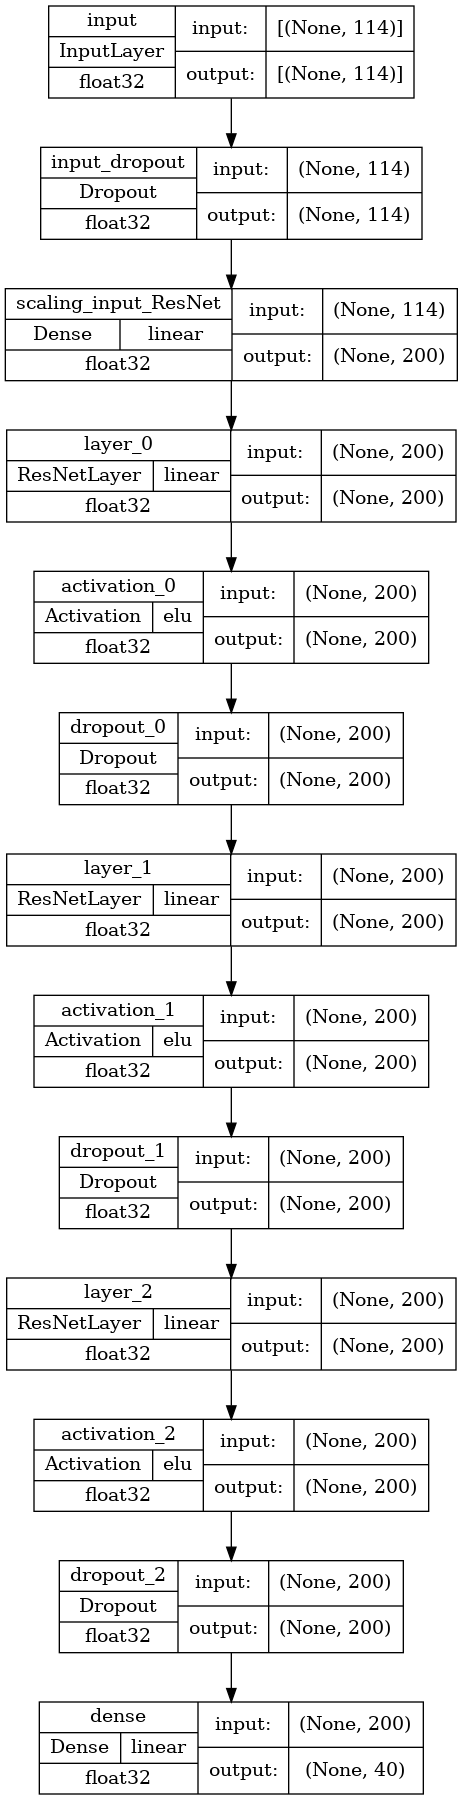

In [9]:
tf.keras.utils.plot_model(
    tf_resnet._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

In [10]:
tf_resnet.summary()

Model: "tf_fc_DEFAULT_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 114)]             0         
                                                                 
 input_dropout (Dropout)     (None, 114)               0         
                                                                 
 scaling_input_ResNet (Dense  (None, 200)              23000     
 )                                                               
                                                                 
 layer_0 (ResNetLayer)       (None, 200)               80400     
                                                                 
 activation_0 (Activation)   (None, 200)               0         
                                                                 
 dropout_0 (Dropout)         (None, 200)               0         
                                               

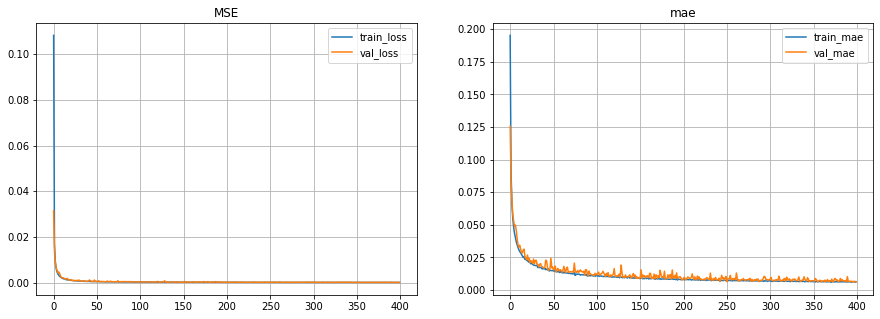

In [11]:
tf_resnet.visualize_convergence()

In [12]:
tf_fc_metrics1 = benchmark1.evaluate_simulator(augmented_simulator=tf_resnet,
                                              eval_batch_size=128,
                                              dataset="all",
                                              shuffle=False,
                                              save_predictions=True
                                             )

 34/391 [=>............................] - ETA: 0s

/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


4/4 [==============================] - 0s 3ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


11/11 [==============================] - 0s 3ms/step


/home/ubuntu/SYSTEMX/seif/seif_dev/LIPS/getting_started/training baselines /../../lips/benchmark/powergridBenchmark.py:351: UserWarning: You indicate to save the predictions, without providing a path. No predictions will be saved!
  warnings.warn(message="You indicate to save the predictions, without providing a path. No predictions will be saved!")


In [13]:
SAVE_PATH = get_path(TRAINED_BASELINES_PATH, benchmark1)
tf_resnet.save(SAVE_PATH)

In [14]:
import numpy as np
eval_metrics = tf_fc_metrics1

In [15]:
print("ML : MAPE90 --> A : mean :{}, std :{}".format(np.mean(list(eval_metrics["test"]["ML"]["mape_90_avg"].values())), np.std(list(eval_metrics["test"]["ML"]["mape_90_avg"].values()))))
print("ML : Inf speed-up :", eval_metrics["test"]["ML"]["TIME_INF"])
print("Rediness : Inf speed-up :", tf_fc_metrics1["test"]["IndRed"]["TIME_INF"])
print("OOD : MAPE90 --> A : mean :{}, std :{}".format(np.mean(list(eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"].values())), np.std(list(eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"].values()))))

ML : MAPE90 --> A : mean :0.0018794984789735378, std :6.2730239130942686e-06
ML : Inf speed-up : 0.125948318047449
Rediness : Inf speed-up : 0.13259111298248172
OOD : MAPE90 --> A : mean :0.1516528092253535, std :5.690003941975774e-05


In [16]:
testset_violoation = [tf_fc_metrics1["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"], tf_fc_metrics1["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"]]
print("Physics : test --> CURRENT_POS : mean :{}, std :{}".format(np.mean(testset_violoation), np.std(testset_violoation)))

Physics : test --> CURRENT_POS : mean :0.029997, std :0.0007190000000000009


In [17]:
oodset_violoation = [tf_fc_metrics1["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"], tf_fc_metrics1["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"]]
print("Physics : ood --> CURRENT_POS : mean :{}, std :{}".format(np.mean(oodset_violoation), np.std(oodset_violoation)))

Physics : ood --> CURRENT_POS : mean :0.0121895, std :0.00019950000000000002
